In [19]:
import itertools
from timeit import default_timer as timer
import z3
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import functools
import random

def comb_and_comp(lst, k):
    if len(lst) < k:
        return
    if k == 0 or len(lst) == 0:
        yield [], lst
    else:
        head, tail = lst[0], lst[1:]
        # Containing head
        for comb, comp in comb_and_comp(tail, k - 1):
            yield [head] + comb, comp
        # Not containing head
        for comb, comp in comb_and_comp(tail, k):
            yield comb, [head] + comp

@functools.cache
def build_indices(grid_size):
    indices_2 = [[[] for j in range(grid_size)] for i in range(grid_size)]
    indices_3 = [[[] for j in range(grid_size)] for i in range(grid_size)]
    for i, j in itertools.product(range(grid_size), range(grid_size)):
        neighbors = []
        for di, dj in itertools.product(range(-1, 2), range(-1, 2)):
            if di == dj == 0:
                continue
            if 0 <= i + di < grid_size and 0 <= j + dj < grid_size:
                neighbors.append((i + di, j + dj))
        for comb, comp in comb_and_comp(neighbors, 2):
            indices_2[i][j].append((comb, comp))
        for comb, comp in comb_and_comp(neighbors, 3):
            indices_3[i][j].append((comb, comp))
    return indices_2, indices_3


def bool_life(solver: z3.Solver, grid_size: int, time_steps: int):
    vars = [[[z3.Bool(f's_{t}_{i}_{j}') for j in range(grid_size)] for i in range(grid_size)] for t in range(time_steps)]

    indices_2, indices_3 = build_indices(grid_size) 
    for t in range(1, time_steps):
        for i, j in itertools.product(range(grid_size), range(grid_size)):

            # Life rules.
            prev = vars[t - 1][i][j]
            next = vars[t    ][i][j]

            def make_count(indices):
                for comb, comp in indices:
                    yield z3.And([vars[t - 1][i][j] for i, j in comb] + [z3.Not(vars[t - 1][i][j]) for i, j in comp])

            count_2 = z3.Or(list(make_count(indices_2[i][j])))
            count_3 = z3.Or(list(make_count(indices_3[i][j])))

            solver.add(next == z3.Or(z3.And(prev, z3.Or(count_2, count_3)), z3.And(z3.Not(prev), count_3)))
    return vars

def pseudobool_life(solver: z3.Solver, grid_size: int, time_steps: int):
    vars = [[[z3.Bool(f's_{t}_{i}_{j}') for j in range(grid_size)] for i in range(grid_size)] for t in range(time_steps)]
    for t in range(1, time_steps):
        for i, j in itertools.product(range(grid_size), range(grid_size)):
            bs = []
            for di, dj in itertools.product(range(-1, 2), range(-1, 2)):
                if di == dj == 0:
                    continue
                if 0 <= i + di < grid_size and 0 <= j + dj < grid_size:
                    bs.append(vars[t - 1][i + di][j + dj])
            prev = vars[t - 1][i][j]
            next = vars[t    ][i][j]
            count_2 = z3.PbEq([(b, 1) for b in bs], 2)
            count_3 = z3.PbEq([(b, 1) for b in bs], 3)
            solver.add(next == z3.Or(z3.And(prev, z3.Or(count_2, count_3)), z3.And(z3.Not(prev), count_3)))
    return vars

def int_life(solver: z3.Solver, grid_size: int, time_steps: int):
    vars = [[[z3.Int(f's_{t}_{i}_{j}') for j in range(grid_size)]
             for i in range(grid_size)] for t in range(time_steps)]

    for t in range(0, time_steps):
        for i, j in itertools.product(range(grid_size), range(grid_size)):
            from z3 import Or, And, Implies, Not
            # Each cell is either 0 or 1.
            solver.add(Or(vars[t][i][j] == 0, vars[t][i][j] == 1))

            if t == 0:
                continue

            # Life rules.
            # `count` symbolically counts the number of alive neighbors cell[i][j] has.
            count = 0
            for di, dj in itertools.product(range(-1, 2), range(-1, 2)):
                if di == dj == 0:
                    continue
                if 0 <= i + di < grid_size and 0 <= j + dj < grid_size:
                    count += vars[t - 1][i + di][j + dj]
            prev = vars[t - 1][i][j]
            next = vars[t][i][j]
            count_2 = count == 2
            count_3 = count == 3
            lhs = next == 1
            rhs = Or(And(prev == 1, Or(count_2, count_3)),
                     And(prev == 0, count_3))
            solver.add(lhs == rhs)

    return vars

def time(grid_size, time_steps, state_maker, setup_fn):
    solver = z3.Solver()
    build_start = timer()
    state = state_maker(solver, grid_size, time_steps)
    setup_fn(solver, state, grid_size, time_steps)
    solve_start = timer()
    assert(solver.check() == z3.sat)
    solve_end = timer()

    return solve_end - solve_start, solve_start - build_start

def constrain(use_bool, solver, state, grid_size, on):
    for i, j in itertools.product(range(grid_size), range(grid_size)):
        if use_bool:
            if (i, j) in on:
                solver.add(state[-1][i][j])
            else:
                solver.add(z3.Not(state[-1][i][j]))
        else:
            solver.add(state[-1][i][j] == (1 if (i, j) in on else 0))

def make_random_setup(use_bool):
    def setup(solver, state, grid_size, time_steps):
        random.seed(0)
        on = set()
        for i, j in itertools.product(range(grid_size), range(grid_size)):
            if random.randint(0, 1) == 1:
                on.add((i, j))
        constrain(use_bool, solver, state, grid_size, on)

    return setup

def make_smiley_setup(use_bool):
    def setup(solver, state, grid_size, time_steps):
        random.seed(0)
        on = set([(1, 1), (1, 4), (3, 1), (4, 2), (4, 3), (3, 4)])
        constrain(use_bool, solver, state, grid_size, on)

    return setup

## Grid size scaling

In [26]:
bool_grid_sizes = list(range(6, 31, 4))
int_grid_sizes = list(range(6, 39, 4))
pb_grid_sizes = list(range(6, 31, 4))
bool_times = []
int_times = []
pb_times = []
for grid_size in tqdm(bool_grid_sizes):
    bool_times.append(time(grid_size, 2, bool_life, make_smiley_setup(True)))
for grid_size in tqdm(int_grid_sizes):
    int_times.append(time(grid_size, 2, int_life, make_smiley_setup(False)))
for grid_size in tqdm(pb_grid_sizes):
    pb_times.append(time(grid_size, 2, pseudobool_life, make_smiley_setup(True)))

100%|██████████| 7/7 [00:47<00:00,  6.79s/it]


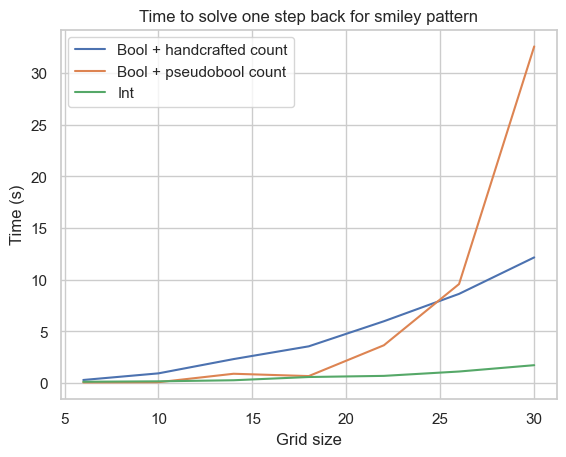

In [32]:
# Plot times vs grid sizes using seaborn
sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax.set_xlabel('Grid size')
ax.set_ylabel('Time (s)')
ax.set_title('Time to solve one step back for smiley pattern')
ax.plot(bool_grid_sizes, [t[0] + t[1] for t in bool_times], label='Bool + handcrafted count')
ax.plot(pb_grid_sizes, [t[0] + t[1] for t in pb_times], label='Bool + pseudobool count')
ax.plot(int_grid_sizes[:-2], [t[0] + t[1] for t in int_times[:-2]], label='Int')
ax.legend()


## Time step scaling

In [35]:
bool_steps = list(range(2, 12))
bool_times = []
for time_steps in tqdm(bool_steps):
    bool_times.append(time(6, time_steps, bool_life, make_smiley_setup(True)))

100%|██████████| 10/10 [00:54<00:00,  5.44s/it]


In [37]:
int_steps = list(range(2, 12))
int_times = []
for time_steps in tqdm(int_steps):
    int_times.append(time(6, time_steps, int_life, make_smiley_setup(False)))

100%|██████████| 10/10 [01:20<00:00,  8.09s/it]


In [39]:

pb_steps = list(range(2, 10))
pb_times = []
for time_steps in tqdm(pb_steps):
    pb_times.append(time(6, time_steps, pseudobool_life, make_smiley_setup(True)))

100%|██████████| 8/8 [02:31<00:00, 18.97s/it]


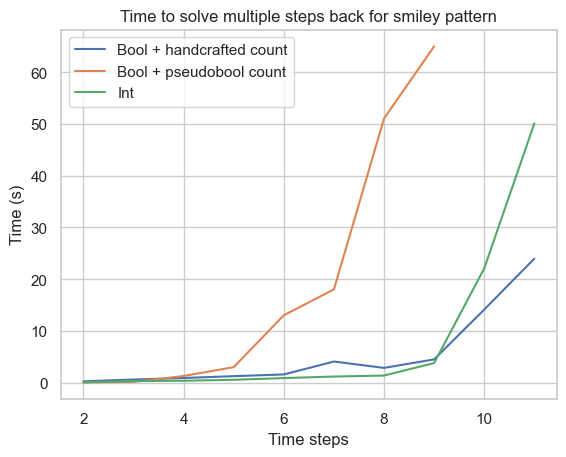

In [40]:

sns.set_theme(style="whitegrid")
fig, ax = plt.subplots()
ax.set_xlabel('Time steps')
ax.set_ylabel('Time (s)')
ax.set_title('Time to solve multiple steps back for smiley pattern')
ax.plot(bool_steps, [t[0] + t[1] for t in bool_times], label='Bool + handcrafted count')
ax.plot(pb_steps, [t[0] + t[1] for t in pb_times], label='Bool + pseudobool count')
ax.plot(int_steps, [t[0] + t[1] for t in int_times], label='Int')
ax.legend()